<a href="https://colab.research.google.com/github/Mehulgoyal353/CODSOFT/blob/main/Iris_Flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [3]:
# Load dataset
df = pd.read_csv("/content/Iris.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Encode label target
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])

# Fitur dan target
X = df.drop('species', axis=1)
y = df['species']

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data train-test
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert ke tensor
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np.values, dtype=torch.long)
y_test = torch.tensor(y_test_np.values, dtype=torch.long)

In [5]:
class IrisMLP(nn.Module):
    def __init__(self, input_size=4, hidden_size=10, output_size=3):
        super(IrisMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
def train_model(X_train, y_train, X_test, y_test, epochs=100, lr=0.01):
    model = IrisMLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    # Evaluate model
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs, 1)
        acc = accuracy_score(y_test, predicted)
        print("Akurasi pada data test:", acc)

    # Save model
    torch.save(model.state_dict(), "model.pth")

    return model, losses

In [7]:
model, losses = train_model(X_train, y_train, X_test, y_test)

Epoch [10/100], Loss: 0.8822
Epoch [20/100], Loss: 0.6272
Epoch [30/100], Loss: 0.4692
Epoch [40/100], Loss: 0.3754
Epoch [50/100], Loss: 0.3067
Epoch [60/100], Loss: 0.2472
Epoch [70/100], Loss: 0.1959
Epoch [80/100], Loss: 0.1535
Epoch [90/100], Loss: 0.1222
Epoch [100/100], Loss: 0.1004
Akurasi pada data test: 1.0


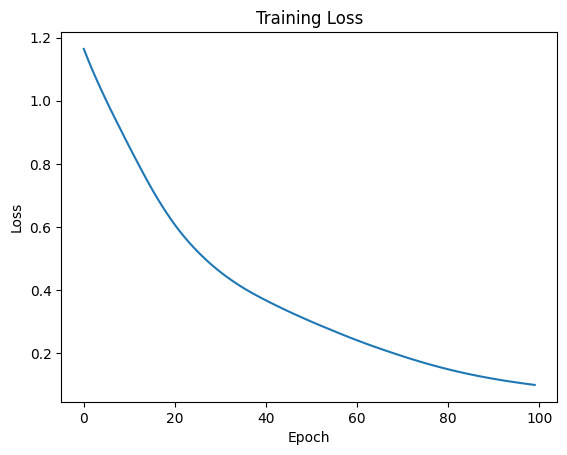

In [8]:
# Plot loss training
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [9]:
# Logistic Regression sebagai pembanding
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_np, y_train_np)
lr_preds = lr_model.predict(X_test_np)
lr_acc = accuracy_score(y_test_np, lr_preds)
print("Akurasi Logistic Regression:", lr_acc)

Akurasi Logistic Regression: 1.0


In [10]:
infer_df = pd.DataFrame(X_test_np, columns=X.columns)
infer_df['species'] = le.inverse_transform(y_test_np)

# Konversi fitur inferensi ke tensor (pakai scaler yang sama)
x_infer = torch.tensor(X_test_np, dtype=torch.float32)

# Load model untuk inference
model_inf = IrisMLP()
model_inf.load_state_dict(torch.load("model.pth"))
model_inf.eval()

with torch.no_grad():
    logits = model_inf(x_infer)
    probs = F.softmax(logits, dim=1)
    preds = logits.argmax(dim=1)

# Decode label prediksi
predicted_labels = le.inverse_transform(preds.numpy())

# Menambahkan hasil prediksi ke dataframe
infer_df['Prediksi_Iris'] = predicted_labels
infer_df['Cocok'] = infer_df['species'] == infer_df['Prediksi_Iris']

# Menyusun ulang kolom agar rapi
kolom_urutan = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species', 'Prediksi_Iris', 'Cocok']
infer_df = infer_df[kolom_urutan]

# Menampilkan 10 prediksi yang benar
print("===== 10 Prediksi BENAR =====")
print(infer_df[infer_df['Cocok'] == True].head(10))

# Menampilkan 10 prediksi yang salah
print("\n===== 10 Prediksi SALAH =====")
print(infer_df[infer_df['Cocok'] == False].head(10))

# Menampilkan jumlah prediksi cocok dan tidak cocok
print("\nJumlah Prediksi Cocok dan Tidak Cocok:")
print(infer_df['Cocok'].value_counts())

# untuk menyimpan hasil inferensi
infer_df.to_csv("IRIS_all.csv", index=False)

===== 10 Prediksi BENAR =====
   sepal_length  sepal_width  petal_length  petal_width          species  \
0      0.310998    -0.587764      0.535296     0.001753  Iris-versicolor   
1     -0.173674     1.726266     -1.170675    -1.181504      Iris-setosa   
2      2.249683    -1.050569      1.786341     1.447956   Iris-virginica   
3      0.189830    -0.356361      0.421564     0.396172  Iris-versicolor   
4      1.159173    -0.587764      0.592162     0.264699  Iris-versicolor   
5     -0.537178     0.800654     -1.284407    -1.050031      Iris-setosa   
6     -0.294842    -0.356361     -0.090227     0.133226  Iris-versicolor   
7      1.280340     0.106445      0.762759     1.447956   Iris-virginica   
8      0.432165    -1.976181      0.421564     0.396172  Iris-versicolor   
9     -0.052506    -0.819166      0.080370     0.001753  Iris-versicolor   

     Prediksi_Iris  Cocok  
0  Iris-versicolor   True  
1      Iris-setosa   True  
2   Iris-virginica   True  
3  Iris-versicolor   

In [11]:
torch.save(model.state_dict(), "model.pth")